# EDA of Covid data for Mecklenburg County
---
- Laura Dahlberg
- January 8, 2021

## Data:
Data for 2020 <br>
From the CDC website https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Restricted-Access-Detai/mbd7-r32t 
<br>To access to the dataset request access to the CDC.

In [1]:
import shutil
import datetime
from dateutil import relativedelta
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib import cm
%matplotlib inline

In [2]:
ROOT = Path("./")
DATA = ROOT/'data'
# [f for f in ROOT.iterdir()]
# [f for f in DATA.iterdir()]

print('ROOT =', ROOT)
print('DATA =', DATA)

ROOT = .
DATA = data


In [3]:
%ls {DATA}

 Volume in drive C has no label.
 Volume Serial Number is FCBC-A9FB

 Directory of C:\Users\laura\covid-19\covid-19_analysis_NC\data

01/08/2021  08:20 PM    <DIR>          .
01/08/2021  08:20 PM    <DIR>          ..
01/07/2021  10:10 PM        15,318,162 MECK_COVID_Cases_Restricted_Detailed_12312020.csv
01/08/2021  06:56 PM             8,024 weekly_covid19_report_mecknc.csv
               2 File(s)     15,326,186 bytes
               2 Dir(s)  289,551,233,024 bytes free


### 0. Reading File

In [4]:
df = pd.read_csv(DATA/'MECK_COVID_Cases_Restricted_Detailed_12312020.csv')
pd.set_option('display.max_columns', None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55801 entries, 0 to 55800
Data columns (total 32 columns):
race_ethnicity_combined    55645 non-null object
current_status             55801 non-null object
cdc_case_earliest_dt       55801 non-null object
cdc_report_dt              55801 non-null object
sex                        55767 non-null object
onset_dt                   22927 non-null object
pos_spec_dt                55784 non-null object
hosp_yn                    55801 non-null object
icu_yn                     55801 non-null object
death_yn                   55801 non-null object
hc_work_yn                 55586 non-null object
pna_yn                     55801 non-null object
abxchest_yn                55801 non-null object
acuterespdistress_yn       55801 non-null object
mechvent_yn                55801 non-null object
fever_yn                   55801 non-null object
sfever_yn                  55801 non-null object
chills_yn                  55801 non-null object
myalgia_y

### Looking at the Data

This is one row of the data to get an idea of what I'm working with.

In [5]:
# df.head(1).T

### Values of column 'death_yn'
Deaths and Survivals

In [6]:
## Total Deaths and Survivals
total_d = pd.DataFrame(df['death_yn'].value_counts())
total_d

,death_yn
No,55238
Yes,544
Missing,18
Unknown,1


In [7]:
PLOT_VALS = total_d['death_yn'].tolist()
PLOT_VALS

[55238, 544, 18, 1]

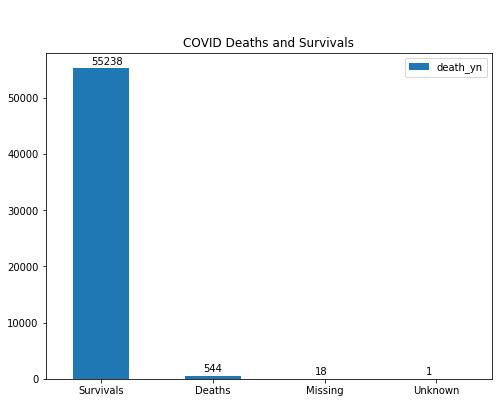

In [8]:
ax = total_d.plot(kind='bar',
                  figsize=(8,6),
                 rot=0,
                 title='\n\nCOVID Deaths and Survivals')
ax.set_xticklabels(['Survivals', 'Deaths', 'Missing', 'Unknown'])
for idx, label in enumerate(PLOT_VALS):
    value = label
    ax.annotate(value,
               (idx, value),
               xytext=(-10, 4),
               textcoords='offset points')

### Totals by Age Group
---


In [9]:
## totals by age group (tba)
tba = df.groupby(['age_group','death_yn'])['death_yn'].count().unstack().fillna(0).reset_index()
#dba.index.rename('index', inplace=True)
## includes Grand total
tba['total'] = tba[['Missing', 'No', 'Unknown', 'Yes']].sum(axis=1)
tba



death_yn,age_group,Missing,No,Unknown,Yes,total
0,0 - 9 Years,1.0,2904.0,0.0,0.0,2905.0
1,10 - 19 Years,4.0,5715.0,0.0,0.0,5719.0
2,20 - 29 Years,8.0,13493.0,1.0,2.0,13504.0
3,30 - 39 Years,2.0,10749.0,0.0,3.0,10754.0
4,40 - 49 Years,0.0,8701.0,0.0,22.0,8723.0
5,50 - 59 Years,1.0,7015.0,0.0,46.0,7062.0
6,60 - 69 Years,1.0,3800.0,0.0,70.0,3871.0
7,70 - 79 Years,1.0,1754.0,0.0,145.0,1900.0
8,80+ Years,0.0,1091.0,0.0,256.0,1347.0


In [60]:
# getting percentage for one group from all ages??
tba_count = df.groupby(['age_group','death_yn'])['death_yn'].count().unstack()

tba_p = (tba_count*100/tba_count.sum()).round(1).fillna(0).reset_index()
tba_p = tba_p.rename(columns = {'No': 'surv', 'Yes':'deaths'})

tba_p


death_yn,age_group,Missing,surv,Unknown,deaths
0,0 - 9 Years,5.6,5.3,0.0,0.0
1,10 - 19 Years,22.2,10.3,0.0,0.0
2,20 - 29 Years,44.4,24.4,100.0,0.4
3,30 - 39 Years,11.1,19.5,0.0,0.6
4,40 - 49 Years,0.0,15.8,0.0,4.0
5,50 - 59 Years,5.6,12.7,0.0,8.5
6,60 - 69 Years,5.6,6.9,0.0,12.9
7,70 - 79 Years,5.6,3.2,0.0,26.7
8,80+ Years,0.0,2.0,0.0,47.1


In [65]:
vals = tba_p['surv'].tolist()
vals

[5.3, 10.3, 24.4, 19.5, 15.8, 12.7, 6.9, 3.2, 2.0]

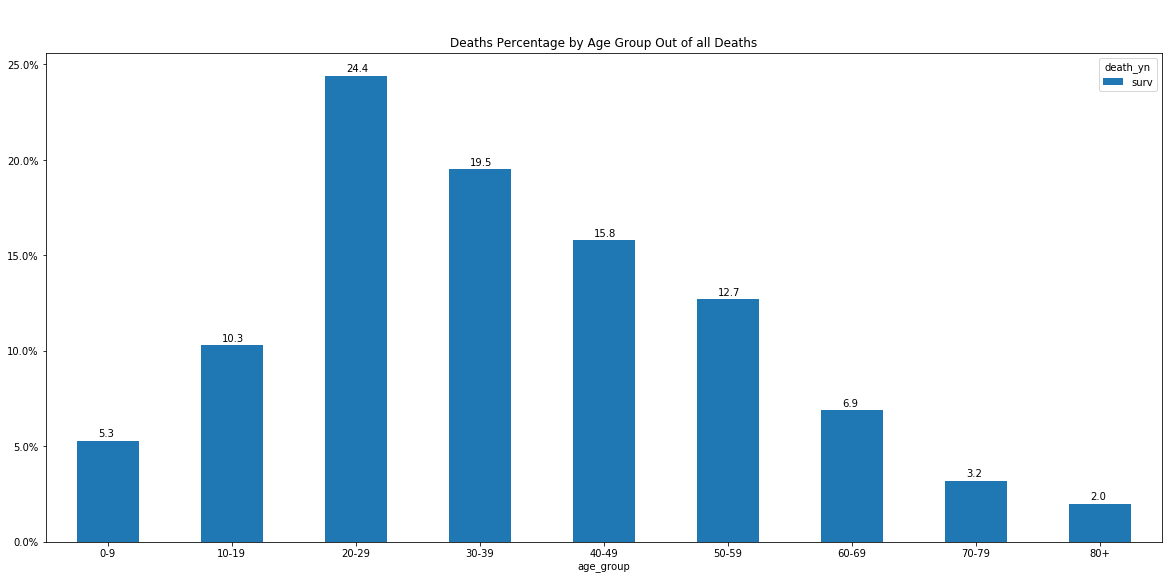

In [73]:
##*** NEED TO FIND BETTER GRAPH FOR THIS DATA ***
##plotting comparison of deaths percentages by age group 
ax = tba_p.plot(x='age_group', y=['surv'],
                kind='bar',
                figsize=(20,9),
                rot=0,
                title= '\n\nDeaths Percentage by Age Group Out of all Deaths')

for idx, label in enumerate(vals):
    value = label
    ax.annotate(value,
               (idx, value),
               xytext=(-10, 4),
               textcoords='offset points')
    
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels(['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']);

In [10]:
## renaming some columns for easy understanding
tba = tba.rename(columns = {'No': 'surv', 'Yes':'deaths'})
# tba
# tba.dtypes

## percentages for missing (miss_p) survival (surv_p),  unknown (unkn_p), deaths (dths_p), total (totl_p)
## percentages by row, within each age group
tba['miss_p'] = ((tba['Missing']*100)/tba['total']).round(1)
tba['surv_p'] = ((tba['surv']*100)/tba['total']).round(1)
tba['unkn_p'] = ((tba['Unknown']*100)/tba['total']).round(1)
tba['dths_p'] = ((tba['deaths']*100)/tba['total']).round(1)
tba['totl_p'] = (tba['total']*100)/tba['total']
tba

death_yn,age_group,Missing,surv,Unknown,deaths,total,miss_p,surv_p,unkn_p,dths_p,totl_p
0,0 - 9 Years,1.0,2904.0,0.0,0.0,2905.0,0.0,100.0,0.0,0.0,100.0
1,10 - 19 Years,4.0,5715.0,0.0,0.0,5719.0,0.1,99.9,0.0,0.0,100.0
2,20 - 29 Years,8.0,13493.0,1.0,2.0,13504.0,0.1,99.9,0.0,0.0,100.0
3,30 - 39 Years,2.0,10749.0,0.0,3.0,10754.0,0.0,100.0,0.0,0.0,100.0
4,40 - 49 Years,0.0,8701.0,0.0,22.0,8723.0,0.0,99.7,0.0,0.3,100.0
5,50 - 59 Years,1.0,7015.0,0.0,46.0,7062.0,0.0,99.3,0.0,0.7,100.0
6,60 - 69 Years,1.0,3800.0,0.0,70.0,3871.0,0.0,98.2,0.0,1.8,100.0
7,70 - 79 Years,1.0,1754.0,0.0,145.0,1900.0,0.1,92.3,0.0,7.6,100.0
8,80+ Years,0.0,1091.0,0.0,256.0,1347.0,0.0,81.0,0.0,19.0,100.0


### Deaths Percentage by Age


In [17]:
## calculating and plotting  monthly Death percentage by age bracket 
# tba[['Missing', 'surv', 'Unknown', 'deaths']].sum().astype(int)

## gettinga of each column
total_counts = pd.DataFrame(tba[['Missing', 'surv', 'Unknown', 'deaths']].sum().astype(int)).T
total_counts

## getting percentages
pct_surv_80 =  


death_yn,Missing,surv,Unknown,deaths
0,18,55222,1,544


<br><br>

### Deaths by Age Bracket
---


In [11]:
## Filtering rows where 'death_yn' is 'yes'
deaths = df[(df['death_yn'].str.contains('Yes'))]
# deaths.head()


In [12]:
# total death by age
dba = df.groupby(['age_group','death_yn'])['death_yn'].count().unstack().fillna(0).reset_index()
#dba.index.rename('index', inplace=True)
# dba['total'] = dba[['Missing', 'No', 'Unknown', 'Yes']].sum(axis=1)
# dba['total'] = dba['Missing', 'No', 'Unknown', 'Yes']

dba

death_yn,age_group,Missing,No,Unknown,Yes
0,0 - 9 Years,1.0,2904.0,0.0,0.0
1,10 - 19 Years,4.0,5715.0,0.0,0.0
2,20 - 29 Years,8.0,13493.0,1.0,2.0
3,30 - 39 Years,2.0,10749.0,0.0,3.0
4,40 - 49 Years,0.0,8701.0,0.0,22.0
5,50 - 59 Years,1.0,7015.0,0.0,46.0
6,60 - 69 Years,1.0,3800.0,0.0,70.0
7,70 - 79 Years,1.0,1754.0,0.0,145.0
8,80+ Years,0.0,1091.0,0.0,256.0


In [13]:
deaths['age_group'].value_counts(normalize=True)

80+ Years        0.470588
70 - 79 Years    0.266544
60 - 69 Years    0.128676
50 - 59 Years    0.084559
40 - 49 Years    0.040441
30 - 39 Years    0.005515
20 - 29 Years    0.003676
Name: age_group, dtype: float64

In [14]:
deaths['age_group'].value_counts()

80+ Years        256
70 - 79 Years    145
60 - 69 Years     70
50 - 59 Years     46
40 - 49 Years     22
30 - 39 Years      3
20 - 29 Years      2
Name: age_group, dtype: int64

### Underlying Medical Conditions
---

medcond_yn

In [15]:
deaths.groupby(['age_group','medcond_yn'])['medcond_yn'].count().unstack()

medcond_yn,No,Unknown,Yes
age_group,,,
20 - 29 Years,NaN,2.0,NaN
30 - 39 Years,NaN,NaN,3.0
40 - 49 Years,4.0,9.0,9.0
50 - 59 Years,1.0,19.0,26.0
60 - 69 Years,1.0,29.0,40.0
70 - 79 Years,2.0,47.0,96.0
80+ Years,11.0,91.0,154.0


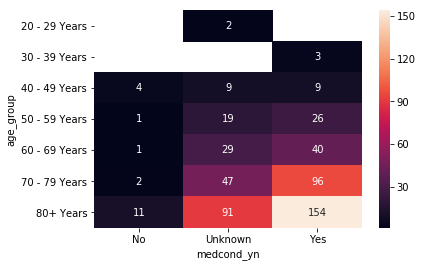

In [16]:
ax = sns.heatmap(deaths.groupby(['age_group','medcond_yn'])['medcond_yn'].count().unstack(), annot=True, fmt='.4g')